# Dust emission

Synthesizer can model thermal dust emission using an energy balance approach.
This is done using dust emission models, which can then be handed to an ``EmissionModel`` to produce a dust emission spectrum, which can be combined with any other spectra in the model.

First we load some common modules, and define a wavelength array over which we will generate our dust emission SED

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from unyt import Angstrom, K, Lsun, Msun, um

from synthesizer.emission_models.dust.emission import (
    Blackbody,
    Casey12,
    Greybody,
    IR_templates,
)

lam = 10 ** (np.arange(3.0, 8.0, 0.01)) * Angstrom

## Parametric models

Below we show a number of simple models, including a blackbody, greybody (non-unity emissivity) and the model detailed in [Casey et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012MNRAS.425.3094C/abstract). 
By default a dust emission model provides a normalised spectrum.

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: overflow encountered in multiply
  out_arr = func(


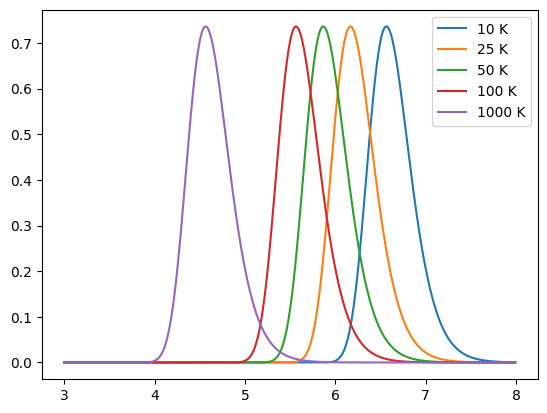

In [2]:
for T in [10, 25, 50, 100, 1000]:
    model = Blackbody(T * K)
    sed = model.get_spectra(lam)
    plt.plot(np.log10(sed.lam), sed.luminosity, label=f"{T} K")

plt.legend()
plt.show()

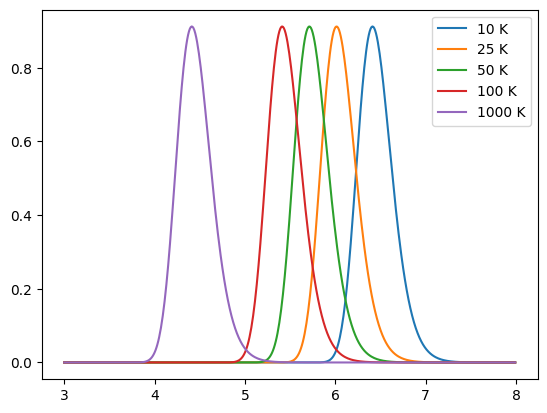

In [3]:
for T in [10, 25, 50, 100, 1000]:
    model = Greybody(T * K, 1.6)
    sed = model.get_spectra(lam)
    plt.plot(np.log10(sed.lam), sed.luminosity, label=f"{T} K")

plt.legend()
plt.show()

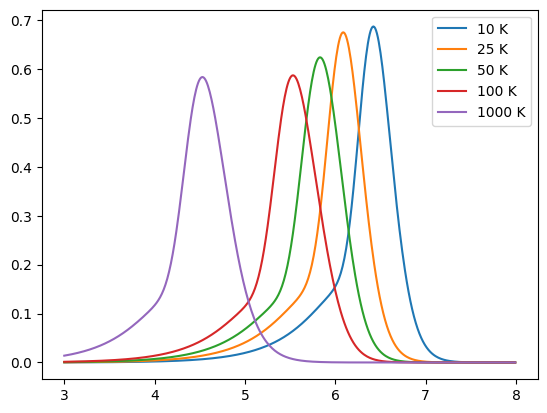

In [4]:
for T in [10, 25, 50, 100, 1000]:
    model = Casey12(T * K, 1.6, 2.0)
    sed = model.get_spectra(lam)
    plt.plot(np.log10(sed.lam), sed.luminosity, label=f"{T} K")

plt.legend()
plt.show()

## Adding CMB heating
At high redshift, the effect of CMB heating is important.
To account for this any dust emission model can incorporate the impact of CMB heating (``cmb_heating``) at a given redshift ($z$).
Below we compare the dust emission spectrum from the Casey+12 model with and without CMB heating:

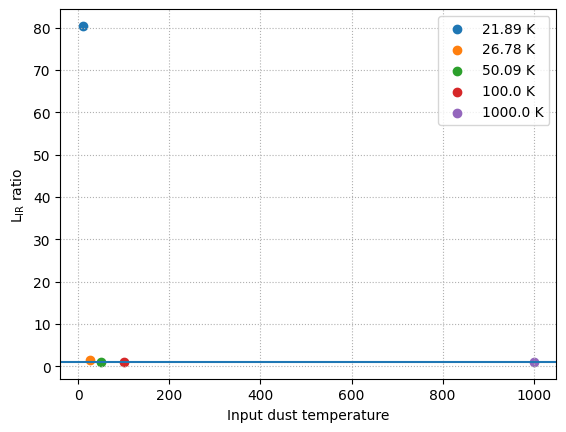

In [5]:
for T in [10, 25, 50, 100, 1000]:
    model = Casey12(T * K, 1.6, 2.0)
    model_cmb = Casey12(T * K, 1.6, 2.0, cmb_heating=True, redshift=7)
    sed = model.get_spectra(lam)
    sed_cmb = model_cmb.get_spectra(lam)
    L_ir_ratio = sed_cmb.measure_window_luminosity(
        window=[8, 1000] * um
    ) / sed.measure_window_luminosity(
        window=[8, 1000] * um
    )  # same as model_cmb.cmb_factor
    plt.scatter(
        T, L_ir_ratio, label=f"{np.around(model_cmb.temperature_z, 2)}"
    )

plt.axhline(y=1)
plt.grid(ls="dotted")
plt.xlabel("Input dust temperature")
plt.ylabel(r"L$_{\rm IR}$ ratio")
plt.legend()
plt.show()

## IR Templates 

### Draine & Li 2007 dust models

The more complex model present in [Draine & Li 2007](https://ui.adsabs.harvard.edu/abs/2007ApJ...657..810D/abstract) is also available; this requires a grid to be loaded in.

Begin by reading in the DL07 grids, which have been created by downloading the ASCII DL07 files and running 
```python
from synthesizer.utils import process_dl07_to_hdf5
process_dl07_to_hdf5()
```

However, you can download these preprocessed grids using the ``synthesizer-download`` command line tool.

```bash
synthesizer-download -d /path/to/destination --dust-grid
```

In [6]:
from synthesizer.grid import Grid

grid_name = "MW3.1"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)
print(grid.axes)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../../../tests/test_grid//MW3.1.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Below we show how to use the DL07 model directly, and plot the dust emission spectrum for a number of dust luminosities.
You can also pass these models to an ``EmissionModel`` and they will be used automatically.

In [7]:
for mdust in [1e7, 1e8, 5e8, 1e9, 5e9]:
    model = IR_templates(
        grid, mdust=mdust * Msun, ldust=1e11 * Lsun, verbose=False
    )
    sed = model.get_spectra(lam)
    plt.plot(
        np.log10(sed.lam),
        np.log10(sed.luminosity),
        label="{:.1e} Msun, <U>={}".format(mdust, model.u_avg),
    )

plt.xlabel("log10(lam/AA)")
plt.ylabel("log10(lnu/(erg/s))")
plt.ylim(40, 45)
plt.legend()
plt.show()

NameError: name 'grid' is not defined